In [3]:
import pathlib
# Bikeshedding way to write to user directory
USER_DIR = str(pathlib.Path.home()) + '/'

In [2]:
#
# Load and parse data
#

import pandas as pd

bad_domains_path = '/data/all_types_domains_balanced_registered_domains_whois_parsed_correct_registrar_names_deduplicated_ids_links.json'
registar_domain_count_path = '/data/registrar_domain_count_flat_deduplicated_links.json'

bad_domains = pd.read_json(bad_domains_path, lines=True)
bad_domains = bad_domains.dropna(subset=['domain', 'created', 'registrar', 'registrar_id']) # drop nulls
# IANA ID 9999 is reserved for Registries acting as Registrars. Out of our scope. This is 16 domains from .pw and .gal
bad_domains = bad_domains[bad_domains['registrar_id'] != 9999]
# This dataset has a new entry for every time the WHOIS server was polled - we only want the one entry of a domain PER registrar
# Some domains have historically been registered at multiple registrars. This removes duplicates without removing that history
bad_domains = bad_domains.drop_duplicates(subset=['registrar_id', 'domain'], keep='first')

registrar_domain_count = pd.read_json(registar_domain_count_path, lines=True)

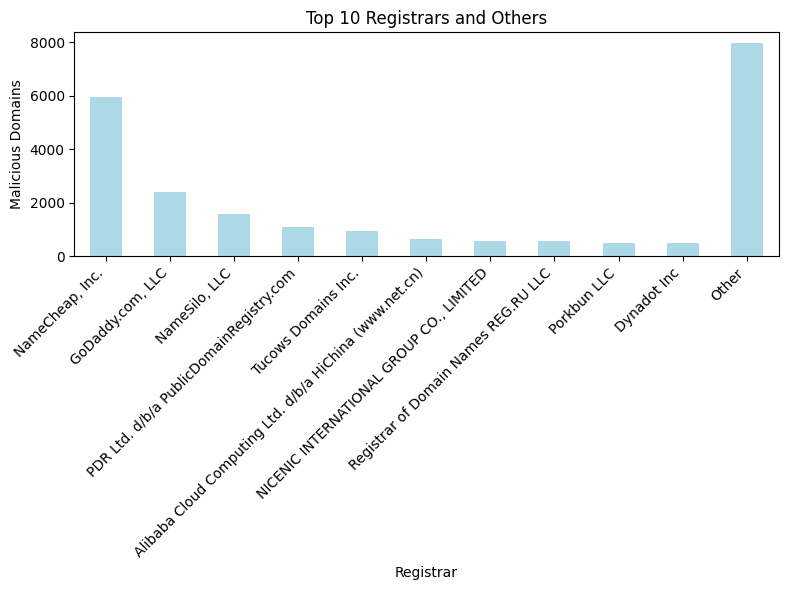

In [4]:
#
# Which registars had the most complaints?
#

import matplotlib.pyplot as plt

# Count the occurrence of each registrar and get top 10
registrar_counts = bad_domains['registrar'].value_counts()
top_10 = registrar_counts.head(10)

# Sum the rest and label as 'Other'
other_count = registrar_counts.iloc[10:].sum()
other_series = pd.Series({'Other': other_count})
top_10 = pd.concat([top_10, other_series])

# Plot the results
plt.figure(figsize=(8, 6))
top_10.plot(kind='bar', color='lightblue')
plt.title('Top 10 Registrars and Others')
plt.xlabel('Registrar')
plt.ylabel('Malicious Domains')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
#
# Which registrars had the most malicious domains per total # of domains registered?
#

# Step 1: Count the number of malicious domains per registrar
# Group by registrar_id and count the domains, while preserving the registrar name
malicious_domain_count = bad_domains.groupby(['registrar_id', 'registrar'])['domain'].count().reset_index()
malicious_domain_count.rename(columns={'domain': 'malicious_domains'}, inplace=True)

# Step 2: Merge with the registrar domain count to get the total number of domains each registrar has
registrar_domain_count_copy = registrar_domain_count[['id', 'name', 'domains']].copy()
registrar_domain_count_copy.rename(columns={'id': 'registrar_id', 'domains': 'total_domains'}, inplace=True)
merged_data = pd.merge(malicious_domain_count, registrar_domain_count_copy, on='registrar_id', how='inner')

# Step 2.5: Apply a (arbitrary) threshold for a minimum number of domains tracked to a registrar
min_domains_threshold = 1000
merged_data = merged_data[merged_data['total_domains'] >= min_domains_threshold]

# Step 3: Calculate the ratio of malicious domains to total domains registered for each registrar
merged_data['malicious_ratio'] = merged_data['malicious_domains'] / merged_data['total_domains']

# Step 4: Sort by the malicious ratio in descending order to find the registrars with the highest ratio
sorted_data = merged_data.sort_values(by='malicious_ratio', ascending=False).reset_index()

# Display the top registrars with the highest ratio of malicious domains
sorted_data[['registrar_id', 'registrar', 'malicious_domains', 'total_domains', 'malicious_ratio']].to_csv(USER_DIR + 'most_malicious.csv', index=False)

In [ ]:
#
# Is there any correlation between price drops and malicious domain purchases?
#  - How we quality a price drop: Look back n days from the purchase date. If price went down more than 5%?, that counts as a price drop
#


In [25]:
#
# Is accepting certain payment methods (like crypto) correlated with more malicious domains?
#  - Need to match tld list service data with registrar_id's
#

# Read the properties of all the registrars
reg_properties = pd.read_csv('/data/registrar_properties.csv')

# Read our random samples of registars
s0 = pd.read_csv('/data/most_malicious.csv')

# Combine data of registrar properties with the random samples of reported registrars
def populate_reg_properties(stratum):
    #stratum.rename(columns={'IANA Number': 'id'}, inplace=True) # use this one if you are reading from a stratum
    stratum.rename(columns={'registrar_id': 'id'}, inplace=True) # use this one if you are reading from most_malicious
    return pd.merge(stratum, reg_properties, on='id', how='left')
    
s0 = populate_reg_properties(s0)

# Do correlation to the % of malicious domains
def correlate_payment(stratum):
    # Create a copy, dropping any rows without data on payment methods
    payment_stratum = stratum.dropna(subset=['payment_methods']).copy()

    # Create a column that stores how many payment methods are accepted per registrar
    payment_stratum.loc[:, 'num_payment_methods'] = payment_stratum['payment_methods'].str.split(',').apply(len)
    
    # Double check that the data is sorted/ranked based on maliciousness percent (not necessary depending what we do...)
    payment_stratum = payment_stratum.sort_values(by='malicious_ratio', ascending=False).reset_index()
    
    # https://realpython.com/numpy-scipy-pandas-correlation-python/
    # Correlation for # of payment methods accepted
    print(f"Corrlation between # of payment methods accepted and percent malicious n = {len(payment_stratum)}")
    print(payment_stratum['num_payment_methods'].corr(payment_stratum['malicious_ratio'], method='pearson'))
    print(payment_stratum['num_payment_methods'].corr(payment_stratum['malicious_ratio'], method='spearman'))
    print(payment_stratum['num_payment_methods'].corr(payment_stratum['malicious_ratio'], method='kendall'))
    
    # Correlation for types of payment methods accepted
    # Create bool values for different payment methods we are interested in (crypto)? 
    payment_stratum.loc[:, 'supports_crypto'] = payment_stratum['payment_methods'].str.contains("crypto", case=False, na=False)

    print(f"Correlation between accepting crypto and percent malicious n = {len(payment_stratum)}")
    print(payment_stratum['supports_crypto'].corr(payment_stratum['malicious_ratio'], method='pearson'))
    print(payment_stratum['supports_crypto'].corr(payment_stratum['malicious_ratio'], method='spearman'))
    print(payment_stratum['supports_crypto'].corr(payment_stratum['malicious_ratio'], method='kendall'))
    

correlate_payment(s0)


Corrlation between # of payment methods accepted and percent malicious n = 48
0.08866836676502873
-0.011739707198929123
0.001940215610290848
Correlation between accepting crypto and percent malicious n = 48
0.1363154929376424
0.21647204707328505
0.17858032782666225


In [24]:
#
# What free services are correlated to more malicious domains (if any)?
#

def correlate_service(stratum, service: str):
    # Create a copy, dropping any rows without data on free services
    service_stratum = stratum.dropna(subset=['free_features']).copy()
    service_stratum.loc[:, 'has_service'] = service_stratum['free_features'].str.contains(service, case=False, na=False)
    
    print(f"Correlation between having '{service}' and percent malicious n = {len(service_stratum)}")
    print(service_stratum['has_service'].corr(service_stratum['malicious_ratio'], method='pearson'))
    #I think these methods don't make sense in this context
    #print(service_stratum['has_service'].corr(service_stratum['malicious_ratio'], method='spearman'))
    #print(service_stratum['has_service'].corr(service_stratum['malicious_ratio'], method='kendall'))

services_to_check = ["url forwarding", "email forwarding", "whois privacy", "email account", "ssl"]

for service in services_to_check:
    correlate_service(s0, service)

Correlation between having 'url forwarding' and percent malicious n = 58
0.19598678822713395
Correlation between having 'email forwarding' and percent malicious n = 58
0.10900858368759754
Correlation between having 'whois privacy' and percent malicious n = 58
0.013889897813980664
Correlation between having 'email account' and percent malicious n = 58
-0.17164914239940887
Correlation between having 'ssl' and percent malicious n = 58
-0.09516346548713087
